# Image Decoder examples

In this notebook we will show usage examples of different flavors of decoders.image.  You will see, that those variants offer the same functionality for CPU backend (`device="cpu"`) and gpu backend (`device="gpu_id"` - where the decoding is accelerated by GPU).

Note that we define all the examples to accept the device parameter, so we can later change it easily.

## Common code

First, let's define some common function that allows us to easily show the images.

In [2]:
from amd.rocal.pipeline import pipeline_def
import amd.rocal.fn as fn
import amd.rocal.types as types
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

seed = 1549361629

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

image_dir = "../../../../data/images/AMD-tinyDataSet/"
batch_size = 4

def show_pipeline_output(pipeline):
    pipe.build()
    images, = pipe.run()
    #if isinstance(images, TensorListGPU):
    images = images.as_cpu()
    show_images(images)

ImportError: cannot import name 'pipeline_def' from 'amd.rocal' (/home/rajy/.local/lib/python3.8/site-packages/amd/rocal/__init__.py)

## Image Decoder (CPU)

`decoders.image` decodes images stored in common formats (including JPEG, JPEG2000, TIFF, PNG)

In [1]:
@pipeline_def(seed=seed)
def image_decoder_pipeline(device="cpu"):
    jpegs, labels = fn.readers.file(file_root=image_dir)
    return fn.decoders.image(jpegs, device=device)
    
pipe = image_decoder_pipeline(batch_size=batch_size, num_threads=1, device="cpu")
show_pipeline_output(pipe)

NameError: name 'pipeline_def' is not defined

## Image Decoder (CPU) with Random Cropping Window Size and Anchor

`decoders.image_random_crop` produces a randomly cropped image. The random cropping window is produced based on a given aspect ratio and area distributions.

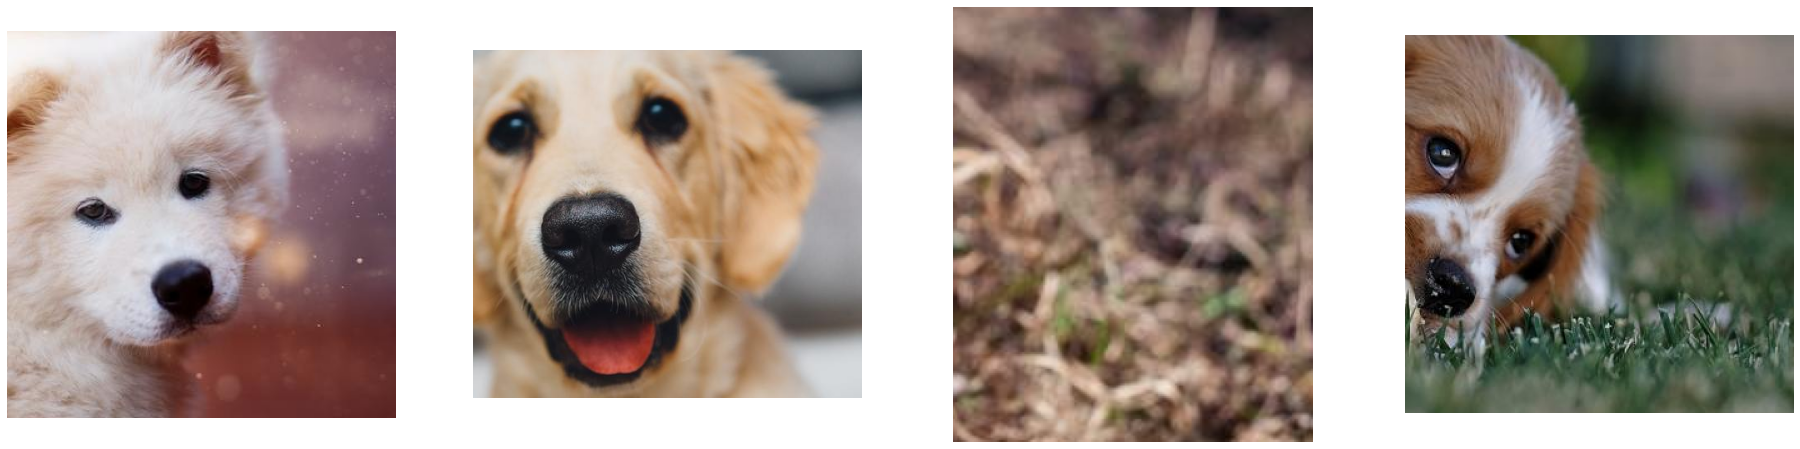

In [3]:
@pipeline_def(seed=seed)
def image_decoder_random_crop_pipeline(device="cpu"):
    jpegs, labels = fn.readers.file(file_root=image_dir)
    images = fn.decoders.image_slice(jpegs, 
                                     output_type=types.RGB,
                                     file_root=image_dir, 
                                     #shard_id=0,
                                     #num_shards=1, 
                                     random_shuffle=True,
                                     device = device)
    return images
    
pipe = image_decoder_random_crop_pipeline(batch_size=batch_size, num_threads=1, device="cpu")
show_pipeline_output(pipe)

## Image Decoder (GPU)

`decoders.image` with mixed backend offloads JPEG decoding to the dedicated hardware unit, if present.

Note, that we repeat the examples shown above, changing only the device parameter. Both the operator and its other parameters stay the same and offer the same functionality - but now we use GPU acceleration.


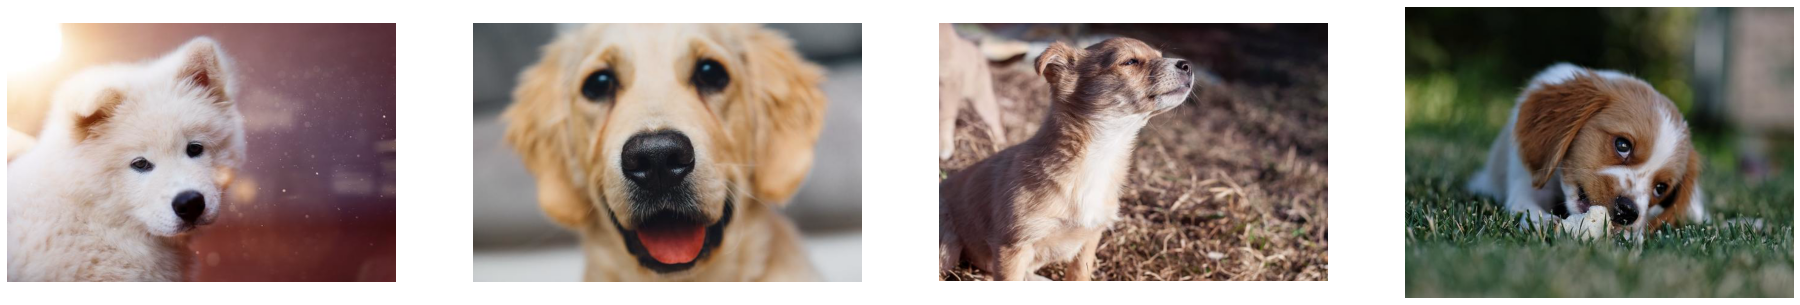

In [6]:
pipe = image_decoder_pipeline(batch_size=batch_size, num_threads=1, device_id=0, device="gpu")
pipe.build()
images, = pipe.run()
show_images(images.as_cpu())

## Image Decoder (GPU) with Random Cropping Window Size and Anchor

`decoders.image_random_crop` produces a randomly cropped image. The random cropping window is produced based on a given aspect ratio and area distributions.

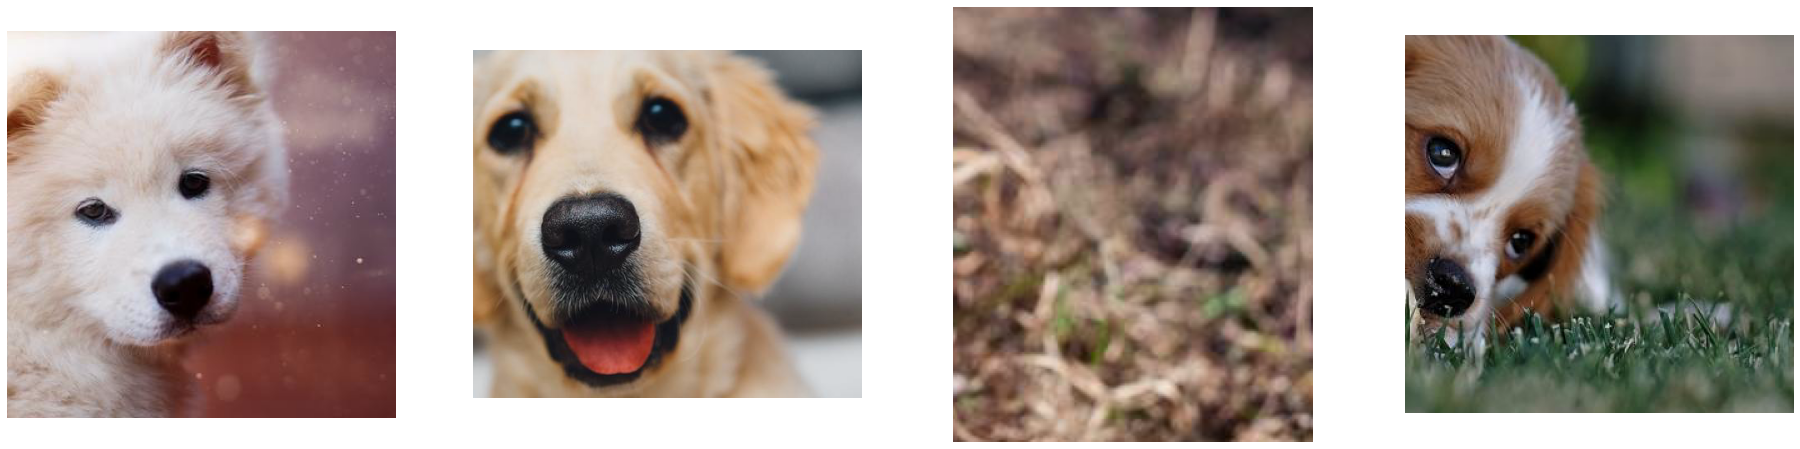

In [7]:
pipe = image_decoder_random_crop_pipeline(batch_size=batch_size, num_threads=1, device_id=0, device="gpu")
show_pipeline_output(pipe)